#### Dataset: [UCF101](https://www.crcv.ucf.edu/research/data-sets/ucf101/)

In [1]:
%matplotlib inline
import os
import copy
import time
import torch
import numpy as np
import torch.nn as nn
from random import shuffle
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

print(torch.__version__) 

1.11.0


In [2]:
# Check availability of GPU

use_gpu = torch.cuda.is_available()
# use_gpu = False # Uncomment in case of GPU memory error
if use_gpu:
    print('GPU is available!')
    device = "cuda"
else:
    print('GPU is not available!')
    device = "cpu"

GPU is available!


In [3]:
# Directories containing extracted features
trainPath = 'ucf101_resnet18Feat/train/'
testPath = 'ucf101_resnet18Feat/test/'

In [4]:
# Creating train list for loading feature tensors
classes = os.listdir(trainPath)
classes.sort()
labels = np.arange(5)
trainShuffList = []
labelShuffList = []
for c in range(5):
    files = os.listdir(trainPath+classes[c])
    for f in files:
        trainShuffList.append(classes[c]+'/'+f)  
        labelShuffList.append(float(labels[c]))
# Shuffling data list and label list
trainList = list(zip(trainShuffList, labelShuffList))
shuffle(trainList)
trainShuffList, labelShuffList = zip(*trainList)

In [5]:
# Creating test list for loading feature tensors
testList = []
testLabelList = []
for c in range(5):
    files = os.listdir(testPath+classes[c])
    for f in files:
        testList.append(classes[c]+'/'+f)  
        testLabelList.append(float(labels[c]))

### Define network architecture

In [6]:
class net_LSTM(nn.Module):
    def __init__(self, input_sz, hidden_sz, nLayers, nClasses):
        super(net_LSTM, self).__init__()       
        self.lstm = nn.LSTM(input_sz, hidden_sz, nLayers, batch_first=True)
        self.fc = nn.Linear(hidden_sz, nClasses)        
    
    def forward(self, x):      
        out, _ = self.lstm(x)       
        # Output from hidden state of last time step
        out = self.fc(out[:, -1, :])  
        return out

### Define train routine

In [9]:
def train(net, inputs, labels, optimizer, criterion):
    net.train()
    inputs, labels = inputs.to(device), labels.to(device)
    # Feed-forward
    outputs = net(inputs)
    _, predicted = torch.max(outputs.data, 1)     
    # Initialize gradients to zero
    optimizer.zero_grad() 
    # Compute loss/error
    loss = criterion(F.log_softmax(outputs,dim=1), labels)
    # Backpropagate loss and compute gradients
    loss.backward()
    # Update the network parameters
    optimizer.step()
    correct = (predicted == labels.data).sum()
    if use_gpu:
        correct = correct.cpu()   
    return net, loss.item(), correct    

### Define test routine

In [10]:
 def test(net, inputs, labels, criterion):
    net.eval()
    with torch.no_grad():
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)  
        # Compute loss/error
        loss = criterion(F.log_softmax(outputs,dim=1), labels)   
        correct = (predicted == labels.data).sum()
        if use_gpu:
            correct = correct.cpu()
    return loss.item(), correct    

### Initialize network

In [12]:
net = net_LSTM(512, 8, 2, 5).to(device) # Input feature length->512, hidden layer size->8, number of layers->2
print(net)

net_LSTM(
  (lstm): LSTM(512, 8, num_layers=2, batch_first=True)
  (fc): Linear(in_features=8, out_features=5, bias=True)
)


### Define loss function and optimizer

In [13]:
criterion = nn.NLLLoss() # Negative Log-likelihood
optimizer = optim.Adam(net.parameters(), lr=1e-4) # Adam

### Train network

Iteration: 1 /1000;  Training Loss: 1.757777 ; Training Acc: 17.417
Iteration: 1 /1000;  Testing Loss: 2.095549 ; Testing Acc: 23.308
Time consumed: 0m 5s
Iteration: 2 /1000;  Training Loss: 1.752737 ; Training Acc: 17.417
Iteration: 2 /1000;  Testing Loss: 2.091961 ; Testing Acc: 22.556
Time consumed: 0m 1s
Iteration: 3 /1000;  Training Loss: 1.748763 ; Training Acc: 17.417
Iteration: 3 /1000;  Testing Loss: 2.089439 ; Testing Acc: 24.060
Time consumed: 0m 1s
Iteration: 4 /1000;  Training Loss: 1.746236 ; Training Acc: 17.417
Iteration: 4 /1000;  Testing Loss: 2.087646 ; Testing Acc: 25.564
Time consumed: 0m 1s
Iteration: 5 /1000;  Training Loss: 1.744258 ; Training Acc: 17.417
Iteration: 5 /1000;  Testing Loss: 2.086777 ; Testing Acc: 21.053
Time consumed: 0m 1s
Iteration: 6 /1000;  Training Loss: 1.741040 ; Training Acc: 17.417
Iteration: 6 /1000;  Testing Loss: 2.084837 ; Testing Acc: 23.308
Time consumed: 0m 1s
Iteration: 7 /1000;  Training Loss: 1.736934 ; Training Acc: 17.417
It

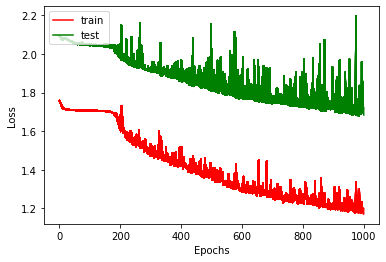

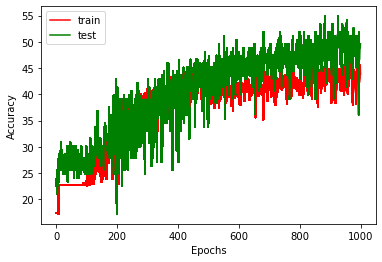

In [14]:
epochs = 1000
bSize = 32 # Batch size
L = 32 # Number of time steps

bCount = len(trainShuffList)//bSize # Number of batches in train set
lastBatch = len(trainShuffList)%bSize # Number of samples in last batch of train set

test_bCount = len(testList)//bSize # Number of batches in test set
test_lastBatch = len(testList)%bSize # Number of samples in last batch of test set

# Lists for saving train/test loss and accuracy
trainLoss = []
trainAcc = []
testLoss = []
testAcc = []

start = time.time()

for epochNum in range(epochs):
    # Shuffling train data for each epoch
    trainList = list(zip(trainShuffList, labelShuffList))
    shuffle(trainList)
    trainShuffList, labelShuffList = zip(*trainList)
    
    trainRunLoss = 0.0
    testRunLoss = 0.0
    trainRunCorr = 0
    testRunCorr = 0
    
    epochStart = time.time()
    
    ## Train
    # Load data tensors batchwise     
    idx = 0    
    for bNum in range(bCount):
        first = True
        # Loading one batch
        for dNum in range(idx,idx+bSize):
            if first:
                loadData = torch.load(trainPath+trainShuffList[dNum])
                sz = loadData.size(0)
                idx1 = torch.from_numpy(np.arange(0,(sz//L)*L,sz//L))
                batchData = torch.index_select(loadData,dim=0,index=idx1).unsqueeze(0)
                batchLabel = torch.Tensor([labelShuffList[dNum]]).long()                          
                first = False                
            else:
                loadData = torch.load(trainPath+trainShuffList[dNum])
                sz = loadData.size(0)
                idx1 = torch.from_numpy(np.arange(0,(sz//L)*L,sz//L))
                tempData = torch.index_select(loadData,dim=0,index=idx1).unsqueeze(0)
                batchData = torch.cat((batchData,tempData), dim=0)
                batchLabel = torch.cat((batchLabel,torch.Tensor([labelShuffList[dNum]]).long()),dim=0)            
        
        # Train the network on current batch
        net, tr_loss, tr_corr = train(net, batchData, batchLabel, optimizer, criterion)
        trainRunLoss += tr_loss
        trainRunCorr += tr_corr
        idx += bSize
        
    # Loading last batch
    if lastBatch != 0:        
        first = True
        for dNum in range(idx,idx+lastBatch):
            if first:
                loadData = torch.load(trainPath+trainShuffList[dNum])
                sz = loadData.size(0)
                idx1 = torch.from_numpy(np.arange(0,(sz//L)*L,sz//L))
                batchData = torch.index_select(loadData,dim=0,index=idx1).unsqueeze(0)
                batchLabel = torch.Tensor([labelShuffList[dNum]]).long()
                first = False                
            else:
                loadData = torch.load(trainPath+trainShuffList[dNum])
                sz = loadData.size(0)
                idx1 = torch.from_numpy(np.arange(0,(sz//L)*L,sz//L))
                tempData = torch.index_select(loadData,dim=0,index=idx1).unsqueeze(0)
                batchData = torch.cat((batchData,tempData), dim=0)
                batchLabel = torch.cat((batchLabel,torch.Tensor([labelShuffList[dNum]]).long()),dim=0)          
        
        # Training network on last batch
        net, tr_loss, tr_corr = train(net, batchData, batchLabel, optimizer, criterion)
        trainRunLoss += tr_loss
        trainRunCorr += tr_corr
    
    # Average training loss and accuracy for each epoch
    avgTrainLoss = trainRunLoss/bCount
    trainLoss.append(avgTrainLoss)
    avgTrainAcc = 100*float(trainRunCorr)/float(len(trainShuffList))
    trainAcc.append(avgTrainAcc)
    
    ## Test
    # Load data tensors batchwise     
    idx = 0    
    for bNum in range(test_bCount):
        first = True
        # Loading one batch
        for dNum in range(idx,idx+bSize): 
            if first:
                loadData = torch.load(testPath+testList[dNum])
                sz = loadData.size(0)
                idx1 = torch.from_numpy(np.arange(0,(sz//L)*L,sz//L))
                batchData = torch.index_select(loadData,dim=0,index=idx1).unsqueeze(0)
                batchLabel = torch.Tensor([testLabelList[dNum]]).long()
                first = False                
            else:
                loadData = torch.load(testPath+testList[dNum])
                sz = loadData.size(0)
                idx1 = torch.from_numpy(np.arange(0,(sz//L)*L,sz//L))
                tempData = torch.index_select(loadData,dim=0,index=idx1).unsqueeze(0)
                batchData = torch.cat((batchData,tempData), dim=0)
                batchLabel = torch.cat((batchLabel,torch.Tensor([testLabelList[dNum]]).long()),dim=0)            
        
        # Test the network on current batch
        ts_loss, ts_corr = test(net, batchData, batchLabel, criterion)
        testRunLoss += ts_loss
        testRunCorr += ts_corr
        idx += bSize
     
    # Loading last batch    
    if test_lastBatch != 0:        
        first = True
        for dNum in range(idx,idx+test_lastBatch):
            if first:
                loadData = torch.load(testPath+testList[dNum])
                sz = loadData.size(0)
                idx1 = torch.from_numpy(np.arange(0,(sz//L)*L,sz//L))
                batchData = torch.index_select(loadData,dim=0,index=idx1).unsqueeze(0)               
                batchLabel = torch.Tensor([testLabelList[dNum]]).long()
                first = False                
            else:
                loadData = torch.load(testPath+testList[dNum])
                sz = loadData.size(0)
                idx1 = torch.from_numpy(np.arange(0,(sz//L)*L,sz//L))
                tempData = torch.index_select(loadData,dim=0,index=idx1).unsqueeze(0)
                batchData = torch.cat((batchData,tempData), dim=0)
                batchLabel = torch.cat((batchLabel,torch.Tensor([testLabelList[dNum]]).long()),dim=0)          
        
        # Test network on last batch
        ts_loss, ts_corr = test(net, batchData, batchLabel, criterion)
        testRunLoss += ts_loss
        testRunCorr += tr_corr
        
    # Average testing loss and accuracy for each epoch
    avgTestLoss = testRunLoss/test_bCount
    testLoss.append(avgTestLoss)
    avgTestAcc = 100*float(testRunCorr)/float(len(testList))
    testAcc.append(avgTestAcc)   

    
    # Plotting training loss vs Epochs
    fig1 = plt.figure(1)        
    plt.plot(range(epochNum+1),trainLoss,'r-',label='train')  
    plt.plot(range(epochNum+1),testLoss,'g-',label='test') 
    if epochNum==0:
        plt.legend(loc='upper left')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')   
    # Plotting testing accuracy vs Epochs
    fig2 = plt.figure(2)        
    plt.plot(range(epochNum+1),trainAcc,'r-',label='train')    
    plt.plot(range(epochNum+1),testAcc,'g-',label='test')        
    if epochNum==0:
        plt.legend(loc='upper left')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
    
    epochEnd = time.time()-epochStart
    print('Iteration: {:.0f} /{:.0f};  Training Loss: {:.6f} ; Training Acc: {:.3f}'\
          .format(epochNum + 1,epochs, avgTrainLoss, avgTrainAcc))
    print('Iteration: {:.0f} /{:.0f};  Testing Loss: {:.6f} ; Testing Acc: {:.3f}'\
          .format(epochNum + 1,epochs, avgTestLoss, avgTestAcc))
    
    print('Time consumed: {:.0f}m {:.0f}s'.format(epochEnd//60,epochEnd%60))
end = time.time()-start
print('Training completed in {:.0f}m {:.0f}s'.format(end//60,end%60))    
           